In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
#read train and test data
train_data = pd.read_excel('训练.xlsx')
test_data_1 = pd.read_excel('测试A.xlsx')
test_data_2 = pd.read_excel('测试B.xlsx')

In [3]:
train_nonnull = train_data.isnull().values
test_nonnull_1 = test_data_1.isnull().values
test_nonnull_2 = test_data_2.isnull().values
train_X = train_data.values
test_X_1 = test_data_1.values
test_X_2 = test_data_2.values
test_id_1 = test_X_1[:, 0]
test_id_2 = test_X_2[:, 0]
train_y = train_X[:, -1]
train_X = train_X[:, 1:-1]
test_X_1 = test_X_1[:, 1:]
test_X_2 = test_X_2[:, 1:]

In [4]:
train_X.shape, test_X_1.shape, test_X_2.shape

((500, 8027), (100, 8027), (121, 8027))

In [5]:
#Merge two data
merged_X = np.concatenate((train_X, test_X_1, test_X_2), axis=0)
merged_nn = np.concatenate((train_nonnull[:, 1:-1], test_nonnull_1[:, 1:], test_nonnull_2[:, 1:]), axis=0)
print(merged_X.shape, merged_nn.shape)

(721, 8027) (721, 8027)


In [6]:
#reverse nn
def BoolReverse(columns):
    tmpm = np.zeros(columns.shape)
    tmpm[columns] = 1
    return tmpm == 0

merged_nn = BoolReverse(merged_nn)

In [7]:
# now find the values that has 0 value and delete such column
first_delete_idxs = []
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    if len(rd) == 0:
        first_delete_idxs.append(i)
    elif len(set(rd)) == 0:
        first_delete_idxs.append(i)
print(len(first_delete_idxs))

62


In [8]:
print(merged_X.shape)
merged_X = np.delete(merged_X, first_delete_idxs, axis=1)
print(merged_X.shape)

(721, 8027)
(721, 7965)


In [9]:
print(merged_nn.shape)
merged_nn = np.delete(merged_nn, first_delete_idxs, axis=1)
print(merged_nn.shape)

(721, 8027)
(721, 7965)


In [10]:
#now find the columns that has only one value
only_one_values = 0
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    if len(set(rd)) == 1:
        merged_X[:, i] = 1.0
        merged_nn[:, i] = True
        only_one_values += 1
print(only_one_values)

1007


In [11]:
def dict2list(dic):
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

# input one array and return the most frequent one
def MostFrequentOne(column):
    itemfreq = {}
    for i in column:
        if i not in itemfreq:
            itemfreq[i] = 1
        else:
            itemfreq[i] += 1
    tmp_dict = sorted(dict2list(itemfreq), key=lambda d:d[1], reverse=True)
    return tmp_dict[0][0]

In [12]:
# one_hot to map str to int
def OneHot_Str(column, retdict = 0):
    syms = set(column)
    sim = {}
    count = 0
    for s in syms:
        sim[s] = count
        count += 1
    cl = len(column)
    retoh = np.zeros((cl, count))
    for i in range(cl):
        s = column[i]
        mi = sim[s]
        retoh[i, mi] = 1.0
    if retdict == 0:
        return retoh
    else:
        return retoh, sim

In [13]:
#now fix the remain data
#if the values in data has one value that is string, then one_hot it, else normalize it
stridxs = []
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    #if len(data) == len(rd) and np.mean(data) == 1.0:
    #    continue
    isstr = False
    for j in range(len(rd)):
        x = rd[j]
        sx = str(type(x))
        if 'str' in sx:
            isstr = True
            break
    if isstr:
        stridxs.append(i)
        # fix null and one_hot it
        if len(rd) < len(data):
            mfc = MostFrequentOne(rd)
            rn = BoolReverse(real)
            data[rn] = mfc
        onehots = OneHot_Str(data)
        merged_X = np.concatenate((merged_X, onehots), axis=1)
    else:
        if len(rd) < len(data):
            if len(set(data)) == 1:
                continue
            rn = BoolReverse(real)
            data[rn] = np.mean(rd)
            mean = np.mean(data)
            std = np.std(data)
            data = (data-mean)/std
            merged_X[:, i] = data
#delete the string columns
print(len(stridxs))
print(merged_X.shape)
merged_X = np.delete(merged_X, stridxs, axis=1)
print(merged_X.shape)

10
(721, 7999)
(721, 7989)


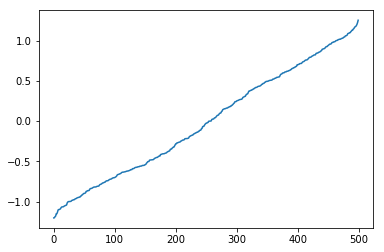

-1.20190859305


In [112]:
tyl = np.sort(train_y)
mean_y = np.mean(tyl)
std_y = np.std(tyl)
tyl = (tyl-np.mean(tyl))/np.std(tyl)
newn = []
for i in tyl:
    x = float(i)
    newn.append(np.arctan(x))
tyl = np.array(newn)
#tyl = np.sqrt(tyl)
plt.plot(np.arange(len(train_y)), tyl)
plt.show()
print(np.min(tyl))
bias_y = np.min(tyl)
tyl -= bias_y

In [118]:
trX, vaX, tr_y, va_y = train_test_split(merged_X[:500], train_y, test_size=0.2, random_state=50)

In [19]:
import xgboost as xgb
from xgboost import plot_importance

In [29]:
params={
    'eta': 0.1,
    'max_depth':5,   
    'min_child_weight':3,
    'gamma':0.1, 
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'booster':'gbtree',
    'objective': 'reg:gamma',
    'nthread':4,
    #'scale_pos_weight': 1,
    'seed':1000,
    'silent':1 ,
    #'eval_metric': 'auc'
}

In [119]:
dtrain = xgb.DMatrix(trX, tr_y)
num_rounds = 400
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)

In [49]:
from xgboost.sklearn import XGBClassifier

In [115]:
def real_ans(y):
    y += bias_y
    y *= std_y
    y += mean_y
    return y

In [121]:
dtest = xgb.DMatrix(vaX)
ans = model.predict(dtest)

In [122]:
print(MSE_np(ans, va_y))

0.03846938784034684


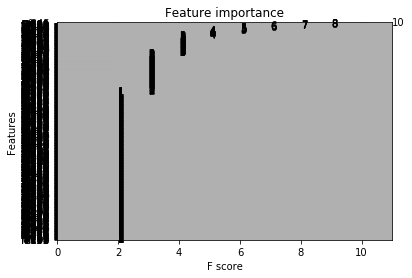

In [117]:
plot_importance(model)
plt.show()

In [48]:
dtrain = xgb.DMatrix(merged_X[:500], train_y)
num_rounds = 400
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)
ta = model.predict(dtrain)
print(MSE_np(ta, train_y))
dtest = xgb.DMatrix(merged_X[500:600])
test1_pred = model.predict(dtest)
test1_pred = test1_pred.reshape(100)
save = pd.DataFrame({'ID':test_id_1, 'value':test1_pred})
save.to_csv('answer.csv', index=False, header=False)

0.029035031935667206


In [50]:
clf = XGBClassifier(
    n_estimators=30,#三十棵树
    learning_rate =0.3,
    max_depth=3,
    min_child_weight=1,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:gamma',
    nthread=12,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=27)

In [78]:
d_train = xgb.DMatrix(trX, label=tr_y)
d_valid = xgb.DMatrix(vaX, label=va_y)
d_test = xgb.DMatrix(merged_X[500:600])
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [79]:
model_bst = xgb.train(params, d_train, 30, watchlist, early_stopping_rounds=500, verbose_eval=10)

[0]	train-gamma-nloglik:4.63447	valid-gamma-nloglik:4.6224
Multiple eval metrics have been passed: 'valid-gamma-nloglik' will be used for early stopping.

Will train until valid-gamma-nloglik hasn't improved in 500 rounds.
[10]	train-gamma-nloglik:2.65673	valid-gamma-nloglik:2.65088
[20]	train-gamma-nloglik:2.16034	valid-gamma-nloglik:2.15676


In [80]:
trnew = model_bst.predict(d_train, pred_leaf=True)
print(trnew.shape)
vanew = model_bst.predict(d_valid, pred_leaf=True)
print(vanew.shape)

(400, 30)
(100, 30)


In [67]:
from sklearn.linear_model import LinearRegression

In [81]:
lr = LinearRegression()

In [82]:
lr.fit(trnew, tr_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
MSE_np(va_y, lr.predict(vanew))

0.04724269015666128

In [290]:
trainX = merged_X[:500]
trX, vaX, tr_y, va_y = train_test_split(trainX, train_y, test_size=0.5, random_state=25)
tmp_r = Regressor(2)
tmp_r.fit(trX, tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [291]:
pred_y = tmp_r.predict(trX)
print(MSE_np(pred_y, tr_y))
pred_y = tmp_r.predict(vaX)
print(MSE_np(pred_y, va_y))

0.00653264688653365
0.0356420475014934


In [294]:
test1_pred = tmp_r.predict(merged_X[500:600])
test1_pred = test1_pred.reshape(100)
save = pd.DataFrame({'ID':test_id_1, 'value':test1_pred})
save.to_csv('answer.csv', index=False, header=False)

In [14]:
import xgboost as xgb

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
import matplotlib.pyplot as plt

In [102]:
#now use pca to reduce its demension
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [127]:
cn = 25
pca = PCA(n_components=cn)
#pca = KernelPCA(n_components=cn, kernel='rbf') 
pca.fit(merged_X) 
psum = 0 
pe = pca.explained_variance_ratio_
#pe = pca.lambdas_
for i in range(cn): 
    e = pe[i] 
    psum += e 
    print(i, psum, e) 
X_new = pca.transform(merged_X) 
print("new shape", X_new.shape)

0 0.999999975997 0.999999975997
1 0.999999988161 1.21642303191e-08
2 0.999999996208 8.04744349027e-09
3 0.999999999192 2.98389444005e-09
4 0.999999999921 7.29025967026e-10
5 0.999999999973 5.15364429733e-11
6 0.999999999996 2.29004577611e-11
7 0.999999999998 2.21812415711e-12
8 0.999999999999 1.16480649017e-12
9 0.999999999999 4.05106542261e-13
10 1.0 3.5635447094e-13
11 1.0 6.3991617151e-14
12 1.0 4.38334783537e-14
13 1.0 2.07982605367e-14
14 1.0 1.57174133905e-14
15 1.0 2.20683238919e-15
16 1.0 1.60405629901e-15
17 1.0 1.79635425041e-17
18 1.0 8.41521642388e-18
19 1.0 5.46518582808e-18
20 1.0 2.57848357376e-18
21 1.0 1.57896209797e-18
22 1.0 1.06665620695e-18
23 1.0 8.67680041323e-19
24 1.0 8.1114062698e-19
new shape (721, 25)


In [128]:
# normalize new_X
for i in range(cn):
    col = X_new[:, i]
    m = np.mean(col)
    s = np.std(col)
    #print(i, np.max(col), np.min(col), m, s)
    col = (col-m)/s
    #print(i, np.max(col), np.min(col), np.mean(col), np.std(col))
    mean = np.mean(col)
    std = np.std(col)
    col = (col-mean)/std
    #print(i, np.mean(col), np.std(col))
    X_new[:, i] = col

In [129]:
# split train, test1, test2 data
trainX = X_new[:500]
test1X = X_new[500:600]
test2X = X_new[600:]
print(trainX.shape, test1X.shape, test2X.shape)

(500, 25) (100, 25) (121, 25)


In [17]:
#Regression by machinr learn
def MSE_np(y, y_pred):
    return np.mean(np.square(y-y_pred))

In [16]:
from sklearn.cross_validation import train_test_split

In [241]:
trX, vaX, tr_y, va_y = train_test_split(trainX, train_y, test_size=0.5, random_state=30)

In [274]:
regressor = Regressor(2)

In [275]:
regressor.fit(trX, tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [276]:
tr_p = regressor.predict(trX)
print(MSE_np(tr_y, tr_p))

0.006243235640536375


In [277]:
va_p = regressor.predict(vaX)
print(MSE_np(va_y, va_p))

0.038457481925419826


In [270]:
regressor = Regressor(2)
regressor.fit(trainX, train_y)
trainp = regressor.predict(trainX)
print(MSE_np(train_y, trainp))

0.0059782197103562746


In [240]:
test1_pred = regressor.predict(test1X)
test1_pred = test1_pred.reshape(100)
save = pd.DataFrame({'ID':test_id_1, 'value':test1_pred})
save.to_csv('answer.csv', index=False, header=False)

# it is a bit fusion to combat all codes from pca to predict to get an good result to get the best prediction result

In [17]:
import time

In [16]:
# 0 : GradientBoostingRegressor
# 1 : ExtraTreesRegressor
# 2 : RandomForestRegressor
# 3 : SVM Regressor(RBF Kernel)
# 4 : KNN Regressor(Distance-weighted)
# 5 : Decision TreeRegressor
# 6 : KNN Regressor (Uniform-weighted)
# 7 : LinearRegression
# 8 : SGDRegressor
# 9 : SVM Regressor(Linear Kernel)

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor

def Regressor(number):
    if number == 0:
        return GradientBoostingRegressor()
    elif number == 1:
        return ExtraTreesRegressor()
    elif number == 2:
        return RandomForestRegressor()
    elif number == 3:
        return SVR(kernel='rbf')
    elif number == 4:
        return KNeighborsRegressor(weights='distance')
    elif number == 5:
        return DecisionTreeRegressor()
    elif number == 6:
        return KNeighborsRegressor(weights='uniform')
    elif number == 7:
        return LinearRegression()
    elif number == 8:
        return SGDRegressor()
    elif number == 9:
        return SVR(kernel='linear')
    else:
        return None

In [126]:
cur_time = time.time()
best_cn = 0
best_val_mse = 1
best_regressor = None
#regressor
for i in range(10):
    #cn
    for j in range(12, 50):
        mses = []
        cn = j 
        pca = PCA(n_components=cn) 
        pca.fit(merged_X) 
        X_new = pca.transform(merged_X)
        for k in range(cn):
            col = X_new[:, k]
            m = np.mean(col)
            s = np.std(col)
            col = (col-m)/s
            maxv = np.max(col)
            minv = np.min(col)
            col = (col-minv)/(maxv-minv)
            X_new[:, k] = col
        trainX = X_new[:500]
        test1X = X_new[500:600]
        test2X = X_new[600:]
        mses = []
        #random state
        for k in range(0, 100):
            trX, vaX, tr_y, va_y = train_test_split(trainX, train_y, test_size=0.33, random_state=k)
            regressor = Regressor(i)
            regressor.fit(trX, tr_y)
            va_p = regressor.predict(vaX)
            mse = MSE_np(va_y, va_p)
            mses.append(mse)
        mse = np.mean(mses)
        if mse < best_val_mse:
            best_cn = j
            best_regressor = i
            best_val_mse = mse
        print(i, j, time.time()-cur_time, mse)
        cur_time = time.time()
print("best regressor", best_regressor, "best cn", best_cn, best_val_mse)

0 12 4.421818017959595 0.0361337366481
0 13 5.161895990371704 0.0364379225721
0 14 4.634726524353027 0.0366321965281
0 15 5.518438339233398 0.0368889988946
0 16 5.839105844497681 0.0369648912494
0 17 5.7945966720581055 0.0367746618891
0 18 6.011782884597778 0.0366208597722
0 19 6.2275230884552 0.0367523276268
0 20 6.504511833190918 0.0371308668496
0 21 6.707685232162476 0.037134715178
0 22 6.737461566925049 0.0368297710411
0 23 6.906983852386475 0.0364255420531
0 24 6.313341379165649 0.0364456896303
0 25 6.551576375961304 0.0360109032812
0 26 7.459532976150513 0.0360653527262
0 27 7.669758081436157 0.0363514185931
0 28 7.875925540924072 0.0364369459674
0 29 7.975120544433594 0.0364017276903
0 30 8.202184200286865 0.0365215516008
0 31 8.378604412078857 0.0363816925565
0 32 8.559360265731812 0.0362917413953
0 33 7.9645607471466064 0.0363089103697
0 34 8.14734435081482 0.0364723748086
0 35 9.1381995677948 0.0364645462011
0 36 9.283891916275024 0.0363806805558
0 37 9.53617000579834 0.03625

5 31 1.572618007659912 0.0588375043001
5 32 1.5785109996795654 0.059568040754
5 33 1.6011929512023926 0.0593986341236
5 34 1.601088047027588 0.0599407438294
5 35 2.4089908599853516 0.0595347554012
5 36 2.4055018424987793 0.0601335901016
5 37 2.392737865447998 0.0603387625446
5 38 2.4781479835510254 0.0601733268981
5 39 2.4932706356048584 0.0602468249606
5 40 2.516441583633423 0.0606662621187
5 41 2.490370750427246 0.0612903201567
5 42 2.5204527378082275 0.0616687042804
5 43 2.5820610523223877 0.0617238988942
5 44 2.5761632919311523 0.0617813850216
5 45 2.5843217372894287 0.0624834001433
5 46 2.6089296340942383 0.0624830453271
5 47 2.618239164352417 0.0618106925011
5 48 2.6347315311431885 0.0620373447313
5 49 2.66113543510437 0.0620357765528
6 12 1.8613669872283936 0.0388306105896
6 13 1.8341479301452637 0.038868712922
6 14 1.8744699954986572 0.0388764864889
6 15 1.8759338855743408 0.0389169034853
6 16 1.890728235244751 0.0389169034853
6 17 1.8737378120422363 0.0389193532713
6 18 1.8860